In [1]:
import numpy as np
import math
import scipy.optimize as optimize
import matplotlib.pyplot as plt

## generate pools

for one pool(100 pools) with ns(5000) species, all species are not anomolous species. (consider add anomolous species) 
number of resources: nr ( nr = 1,2,...,7)

we need generate the growth rate $g_{\mu i}$. $\sum_i g_{\mu i}^2=1 \mathrm{hr}^{-2}$

In [2]:
def generate_anomolous_species(ns, nr):
    vector = []
    for _ in range(ns):
        vector = np.random.uniform(0,1,size=nr)
        vector /= np.linalg.norm(vector)
        vectors.append(vector)
    return vectors

In [3]:
def generate_anomolous_nutrient_rank(ns, nr):
    vectors = []
    for _ in range(ns):
        vector = random.sample(range(nr), nr)
        vectors.append(vector)
    return vectors

In [4]:
def generate_random_vectors(ns, nr):
    vectors = []
    ranks = []

    for _ in range(ns):
        vector = np.random.uniform(0,1,size=nr)
        vector /= np.linalg.norm(vector)
        vectors.append(vector)

        # Generate ranks
        rank = np.argsort(-vector)
        ranks.append(rank)

    return vectors, ranks

##the rank should be used like maxrate-vectors[rank[0]], secondrate-vectors[rank[1]]...

In [5]:
# generate_anomolous growth rate & rank
'''
spciesGR = []
rank = []
for i in range(ns):
    spciesGR.append(generate_anomolous_species(ns, nr))
    rank.append(generate_anomolous_nutrient_rank(ns, nr))
'''

'\nspciesGR = []\nrank = []\nfor i in range(ns):\n    spciesGR.append(generate_anomolous_species(ns, nr))\n    rank.append(generate_anomolous_nutrient_rank(ns, nr))\n'

In [6]:
def delta_n(n0,gr,t):
    # n0,gr,t are all numbers
    try:
        delta_n = n0 * math.exp(gr * t) - n0
        #if t<0.000001:
           # print("gr = %s"%(gr))
           # print("t = %s"%(t))
           # print("math.exp(gr * t) = %s"%(math.exp(gr * t)))
            #print("n0 = %s"%(n0))
            #print("delta_n = %s"%(delta_n))
        return delta_n
    except OverflowError:
        print("OverflowError: Input value is too large for exponential calculation.")
        print(gr)
        print(t)
        return None

In [7]:
def delta_c(n0,gr,boolgr,delta_t,nri ,ns):
    # gr is a matrix for growth rate 
    # nri is the index of resource from 0 to nr-1
    #boolgr is a vector to determine whether the bug is consuming the resource 
    ###### we need to figure how to generate boolgr
    deltaC = 0
    for i in range(ns):
        deltaC = deltaC + boolgr[i]*delta_n(n0[i],gr[i][nri],delta_t)
        #print(gr[i][nri])
    return deltaC

In [8]:
#####
def find_root(f, low, high, precision):
    while high - low > precision:
        mid = (low + high) / 2.0
        if f(mid) < 0:
            low = mid
        else:
            high = mid
    return (low + high) / 2.0

### scipy.optimize.root

In [9]:
def runouttime(nr,nri, boolgr, n0, s, gr):  
    #calculate the runout time for the (nri+1)th neutrient
    #n0(vec),s(number) remaining bug & neutrient concentration
    #import scipy.optimize as optimize
    if s < 0.000000000001:
        solution = 0 
    elif max(boolgr[nri])==0:
        solution = np.nan
    else:
        def equation(t):
            deltaC = 0
            for i in range(len(n0)):
                nextgr = sum(gr[i][j]*boolgr[j][i] for j in range(nr))
                deltaC = deltaC + delta_n(n0[i], nextgr, t)*spciesGR[i][nri]*boolgr[nri][i]/nextgr
                
            #deltaC = sum(boolgr[i] * delta_n(n0[i], gr[i][nri], t) for i in range(len(n0)))
            return deltaC - s
        #solution = optimize.fsolve(equation, 1.0)
        solution = find_root(equation, 0, 100, 0.000000000001)
    return solution

### get_boolgr for diauxie

In [10]:
def normalize_vector(v):
    sum_of_components = np.sum(v)
    if sum_of_components == 0:
        return v
    else:
        return v / sum_of_components

In [11]:
def get_boolgr(x, nsi, c0, n0):   # x is a vec           
    # spic_resource[i] = k the i+1_th resource is used by the k+1_th species
    #print(x)
    xxx = np.copy(x)
    for i in range(nr):
        if c0[i] < 0.000000000001:
            xxx[i] = 0
    boolgr = normalize_vector(xxx)
    
    if n0[nsi] < 0.000000000001:
        boolgr = np.zeros(len(c0))
    
    #if sum(boolgr) == 0:
        #print(c0)
        #print(n0)
        #print(nsi)
        #print(boolgr)
        #print("__________")
    return boolgr

In [12]:
def sigma(s):
    # Compute the squared differences
    squared_diff = [(si - 1/3)**2 for si in s]
    # Calculate the average of squared differences
    average_squared_diff = np.mean(squared_diff)
    # Calculate the standard deviation
    sigma_RS = np.sqrt(average_squared_diff)
    return sigma_RS

In [13]:
def PseudoUniformSupply(size = 3, k = 0):
    vector = np.random.uniform(k+0, k+10, size)
    vector /= sum(vector)
    return vector, sigma(vector)

In [14]:
###test get_boolgr
'''
nr=4
ns=4
'''
rank = np.array([[4, 2, 1, 3],
       [1, 2, 4, 3],
       [3, 2, 4, 1],
       [4, 1, 3, 2]])

rank = rank - 1
#rank = rank.transpose()
print(rank)

[[3 1 0 2]
 [0 1 3 2]
 [2 1 3 0]
 [3 0 2 1]]


In [15]:
#print(boolgr.transpose())

In [16]:
def onecycle(n0new, c0new,spciesGR,round1):
    printround = -1
    ### calculate the dynamic within one cycle
    # n0 vector length ns
    # c0 vector length nr
    Nnich = 0
    n0 = [n0new]
    c0 = [c0new]
    time_node = [0] ## time_node start from 0

    while True:
        boolgr = []
        
        for i in range(ns):
            boolgr_temp = get_boolgr(x[i], i, c0[Nnich],n0[Nnich])
            boolgr.append(boolgr_temp)
            
        boolgr = np.array(boolgr).transpose() 
        if round1 == printround:
            print("boolgr:")
            print(boolgr)
        runoutT = [runouttime(len(c0new),i, boolgr, n0[Nnich],c0[Nnich][i],spciesGR) for i in range(nr)]
        if round1 == printround:
            print("t:")
            print(runoutT)
            print(runoutT)
        try:
            deltaT, runout_index = min((val, idx) for (idx, val) in enumerate(runoutT) if val > 0)
            #deltaT, runout_index = min((val, idx) for (idx, val) in enumerate(runoutT))
        except ValueError:
            break
            
        if round1 == printround:
            print("deltaT:")
            print(deltaT)
        time_node.append(float(deltaT+time_node[Nnich]))
        
        #calculate next_n0
        next_n0 = []
        deltaN = []
        nextgrlist = []
        for i in range(ns):
            nextgr = sum(spciesGR[i][j]*boolgr[j][i] for j in range(nr))
            deltaN.append(delta_n(n0[Nnich][i],nextgr,deltaT))
            next_n0.append(n0[Nnich][i] + deltaN[-1])
            nextgrlist.append(nextgr)
        #next_n0 = [n0[Nnich][i] + delta_n(n0[Nnich][i],sum(spciesGR[i][j],deltaT)*boolgr[j][i] for j in range(nr)) for i in range(ns)]
            #print("nextgr is %s"%(nextgr))      
                        
        n0.append(next_n0) 
        #$efkufilwueajoriuhekurj
        next_c0 = []
        [(c0[Nnich][j]-delta_c(n0[Nnich],spciesGR,boolgr[j],deltaT,j,ns))for j in range(nr)]
        for j in range(nr):
            deltaC = 0
            for i in range(ns):
                deltaC = deltaC + deltaN[i]*spciesGR[i][j]*boolgr[j][i]/nextgrlist[i]
            next_c0.append(c0[Nnich][j] - deltaC)
        
        c0.append(next_c0) 
        if round1 == printround:
            print("next c0 is %s" %(c0))
        
        
        Nnich += 1
    #if round1 == printround:
        #print(time_node)
        #print("nich is %s" %(Nnich))
        #plt.plot(time_node, n0)
    #print("______________")
    #print(time_node)

    #print("nich is %s" %(Nnich))
    #print(time_node[-1])
    return n0, c0, time_node

### read pickle file

In [17]:
import pickle

# Open the .pkl file in binary mode for reading
#with open('3N4R_all_comm.pkl', 'rb') as file:
    # Load the object from the file
    
with open('1_season_co-ut_uniform_species.pkl', 'rb') as file:    
    data = pickle.load(file)

In [18]:
print(data['communities'][34])
#print(len(data['communities']))

{'g': array([[1.02716911, 1.05962328, 1.13838023, 1.52877844],
       [0.71721274, 1.20288152, 0.99507266, 0.82779937],
       [1.17324312, 1.01596274, 1.30832168, 1.17057398],
       [1.26578919, 1.20858362, 0.84285457, 0.61665249]]), 'x': array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]]), 'N_dep_orders': 24, 'allowed_orders': array([[1, 2, 3, 4],
       [1, 2, 4, 3],
       [1, 3, 2, 4],
       [1, 3, 4, 2],
       [1, 4, 2, 3],
       [1, 4, 3, 2],
       [2, 1, 3, 4],
       [2, 1, 4, 3],
       [2, 3, 1, 4],
       [2, 3, 4, 1],
       [2, 4, 1, 3],
       [2, 4, 3, 1],
       [3, 1, 2, 4],
       [3, 1, 4, 2],
       [3, 2, 1, 4],
       [3, 2, 4, 1],
       [3, 4, 1, 2],
       [3, 4, 2, 1],
       [4, 1, 2, 3],
       [4, 1, 3, 2],
       [4, 2, 1, 3],
       [4, 2, 3, 1],
       [4, 3, 1, 2],
       [4, 3, 2, 1]], dtype=int32), 'possible_dep_order': [array([4, 1, 3, 2], dtype=int32)], 'possible_

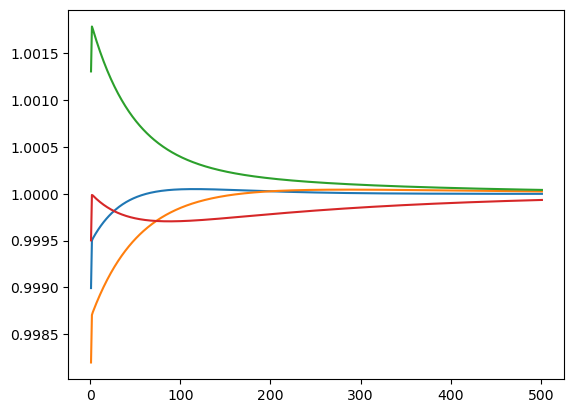

surive num of the 8 th trial is 4.000000


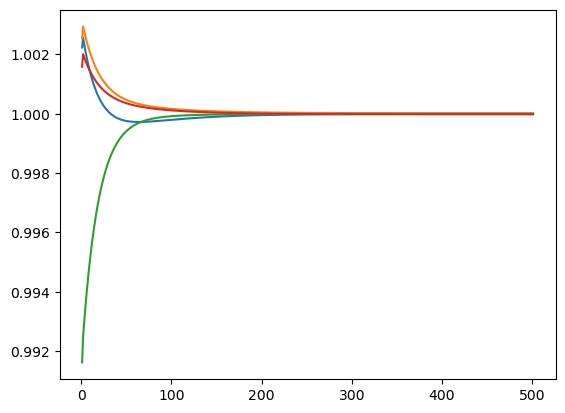

surive num of the 10 th trial is 4.000000


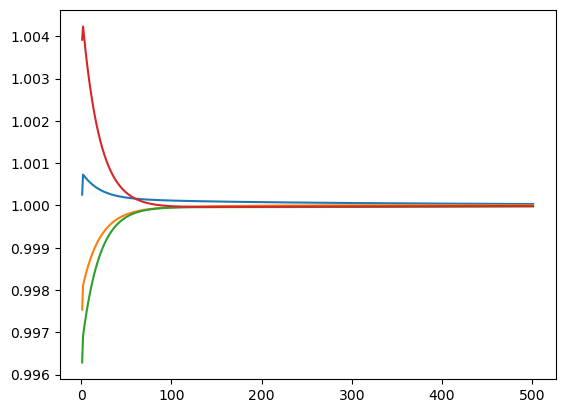

surive num of the 23 th trial is 4.000000


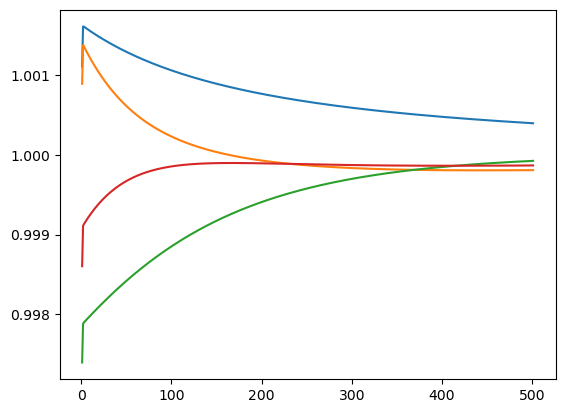

surive num of the 31 th trial is 4.000000


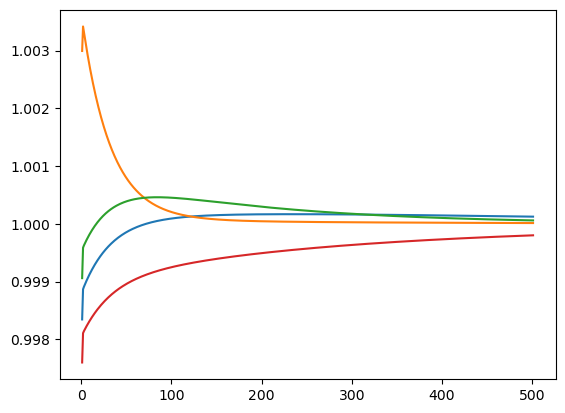

surive num of the 32 th trial is 4.000000


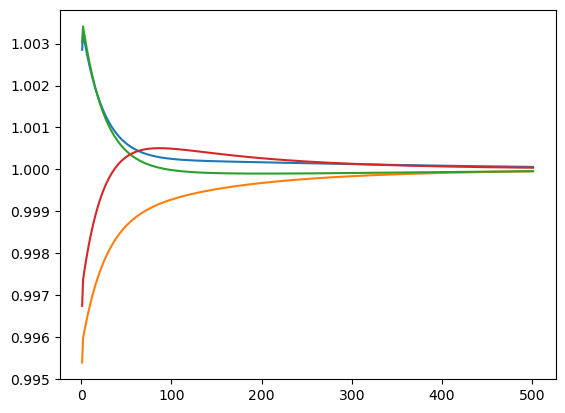

surive num of the 34 th trial is 4.000000


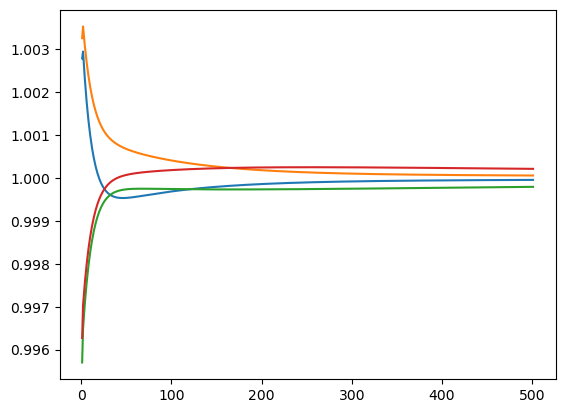

surive num of the 36 th trial is 4.000000


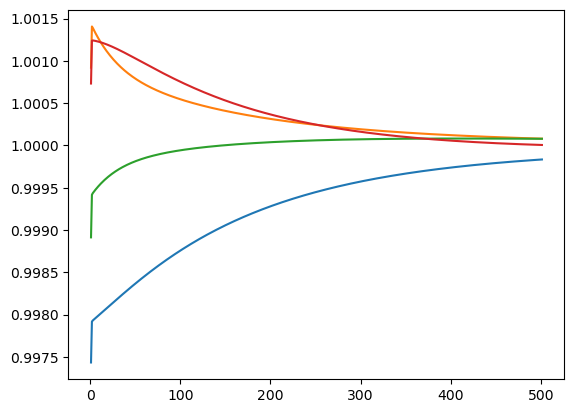

surive num of the 46 th trial is 4.000000


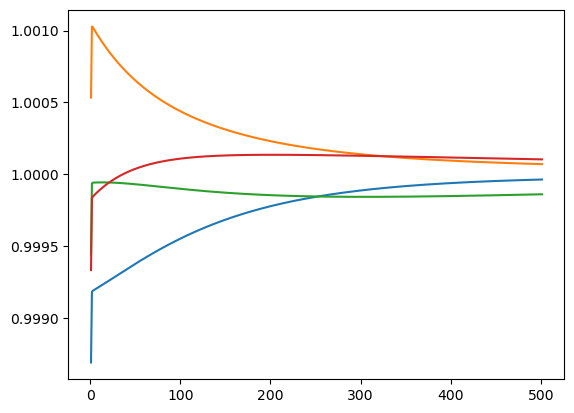

surive num of the 48 th trial is 4.000000


In [24]:
ns = 4
nr=4
stat = np.zeros(ns+1)

onenum = 0


for iii in range(50):
    #iii = 34
    ### first check possible_resource_supply
    if data['communities'][iii]['possible_resource_supply'] == []:
        continue
    else:
        onenum = onenum + 1
        spciesGR = data['communities'][iii]['g']
        
        #rank = data['communities'][iii]['pref_list']
        c0 = []
        #for i in range(nr):
            #c0[0].append(1/nr)
        c0.append(data['communities'][iii]['possible_resource_supply'][0])  
        
        x = np.copy(data['communities'][iii]['x'])
        #print(ns)

        ####################################################
        ##set up dilution factor 
        DF = 100


        lendata = 100
        #Ntr = 32

        #start = 100 
        #for Ntr in range(start, 10000):

        #set up initial population
        n0 = [[]]
        mean = 0 
        stddev = 0.0001
        for i in range(ns):
            n0[0].append(0.0095)

        time_node = [0]

        #record Population fractions at the end of each growth cycle

        populationEndRelative = []
        populationEndAbs = []
        
        #populationEndAbs.append(n0[0])


        #generate the first cycle
        ntrial, ctrial, timenodetrial = onecycle(n0[0],c0[0],spciesGR,0)

        populationEndAbs.append(ntrial[-1])

        log_N = normalize_vector(ntrial[-1])
        #print(log_N)
        populationEndRelative.append(log_N)

        #generate other cycle
        cycleNum = 500

        realcyc = 1

        for k in range(cycleNum):
            #print("c0")
            #print(c0)
            n0temp = []
            for i in range(len(ntrial[-1])):
                if ntrial[-1][i]<0.000000000001:
                    n0temp.append(0)
                else:
                    n0temp.append(ntrial[-1][i]/ DF)
            n0[0] = n0temp
            #print("n0")
            #print(n0[0])
            #c0[0] , avg = PseudoUniformSupply(nr)
            # visualize
            #print(c0)
            ntrial, ctrial, timenodetrial = onecycle(n0[0],c0[0],spciesGR,k)

            #print(ntrial[-1])
            if max(ntrial[-1])<0.000000000001:
                populationEndRelative.append(ntrial[-1])
                break
            log_N = normalize_vector(ntrial[-1])

            realcyc = realcyc + 1
            populationEndAbs.append(ntrial[-1])
            populationEndRelative.append(log_N)


        populRelative = np.transpose(populationEndRelative)
        populAbs = np.transpose(populationEndAbs)

        linear_space = np.linspace(1,realcyc ,realcyc)
        
        
        for xx in range(ns):
                #if x not in extinct_spicies:
        #xx = 3
            plt.plot(linear_space, populAbs[xx])
        plt.show()
        
        
        ### check survive
        survNum = 0

        if realcyc > cycleNum - 2:
            for i in range(ns):
                if populRelative[i][-1] > 0.01:
                    survNum = survNum + 1
        else:
            survNum = 1
        stat[int(survNum)] = stat[int(survNum)]+1
        print("surive num of the %s th trial is %f" %(iii,survNum))

In [21]:
print(onenum)

9


In [22]:
print(sum(stat))

9.0


In [23]:
print(stat/2493)

[0.         0.         0.         0.         0.00361011]
